# Chapter 17: Representation Learning and Generative Learning Using Autoencoders and GANs
# Representation Learning dan Generative Learning dengan Autoencoders dan GANs

## Pengantar

Chapter ini membahas dua paradigma penting dalam deep learning:

**1. Representation Learning (Autoencoders)**
- Belajar representasi data yang efisien
- Dimensionality reduction
- Feature extraction otomatis
- Data compression

**2. Generative Learning (GANs)**
- Generate data baru yang mirip dengan training data
- Adversarial training
- Creative AI applications
- Data augmentation

**Aplikasi:**
- Image generation dan manipulation
- Anomaly detection
- Data compression
- Style transfer
- Super resolution

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from IPython.display import clear_output
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU Available: False


## Data Preparation

Kita akan menggunakan beberapa dataset untuk demonstrasi:
1. **Olivetti Faces Dataset** - untuk face reconstruction dan generation
2. **MNIST** - untuk digit generation dan anomaly detection
3. **Fashion-MNIST** - untuk clothing item generation

Dataset ini akan membantu kita memahami bagaimana autoencoders dan GANs bekerja pada data visual.

In [2]:
# Load datasets
def load_datasets():
    """Load and prepare datasets for autoencoders and GANs"""
    
    # 1. Olivetti Faces Dataset
    print("Loading Olivetti Faces dataset...")
    faces = fetch_olivetti_faces(shuffle=True, random_state=42)
    X_faces = faces.data
    
    # Normalize to [0, 1]
    X_faces = X_faces.astype('float32')
    
    # Split into train/test
    X_faces_train, X_faces_test = train_test_split(X_faces, test_size=0.2, random_state=42)
    
    print(f"Faces - Train: {X_faces_train.shape}, Test: {X_faces_test.shape}")
    
    # 2. MNIST Dataset
    print("Loading MNIST dataset...")
    (X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test) = keras.datasets.mnist.load_data()
    
    # Normalize to [0, 1] and reshape
    X_mnist_train = X_mnist_train.astype('float32') / 255.0
    X_mnist_test = X_mnist_test.astype('float32') / 255.0
    
    print(f"MNIST - Train: {X_mnist_train.shape}, Test: {X_mnist_test.shape}")
    
    # 3. Fashion-MNIST Dataset
    print("Loading Fashion-MNIST dataset...")
    (X_fashion_train, y_fashion_train), (X_fashion_test, y_fashion_test) = keras.datasets.fashion_mnist.load_data()
    
    # Normalize to [0, 1]
    X_fashion_train = X_fashion_train.astype('float32') / 255.0
    X_fashion_test = X_fashion_test.astype('float32') / 255.0
    
    print(f"Fashion-MNIST - Train: {X_fashion_train.shape}, Test: {X_fashion_test.shape}")
    
    return {
        'faces': (X_faces_train, X_faces_test),
        'mnist': ((X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test)),
        'fashion': ((X_fashion_train, y_fashion_train), (X_fashion_test, y_fashion_test))
    }

# Load all datasets
datasets = load_datasets()

Loading Olivetti Faces dataset...
downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\pandu\scikit_learn_data
Faces - Train: (320, 4096), Test: (80, 4096)
Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MNIST - Train: (60000, 28, 28), Test: (10000, 28, 28)
Loading Fashion-MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Fashion-MNIST - Train: (60000, 28, 28), Test: (10000, 28, 28)


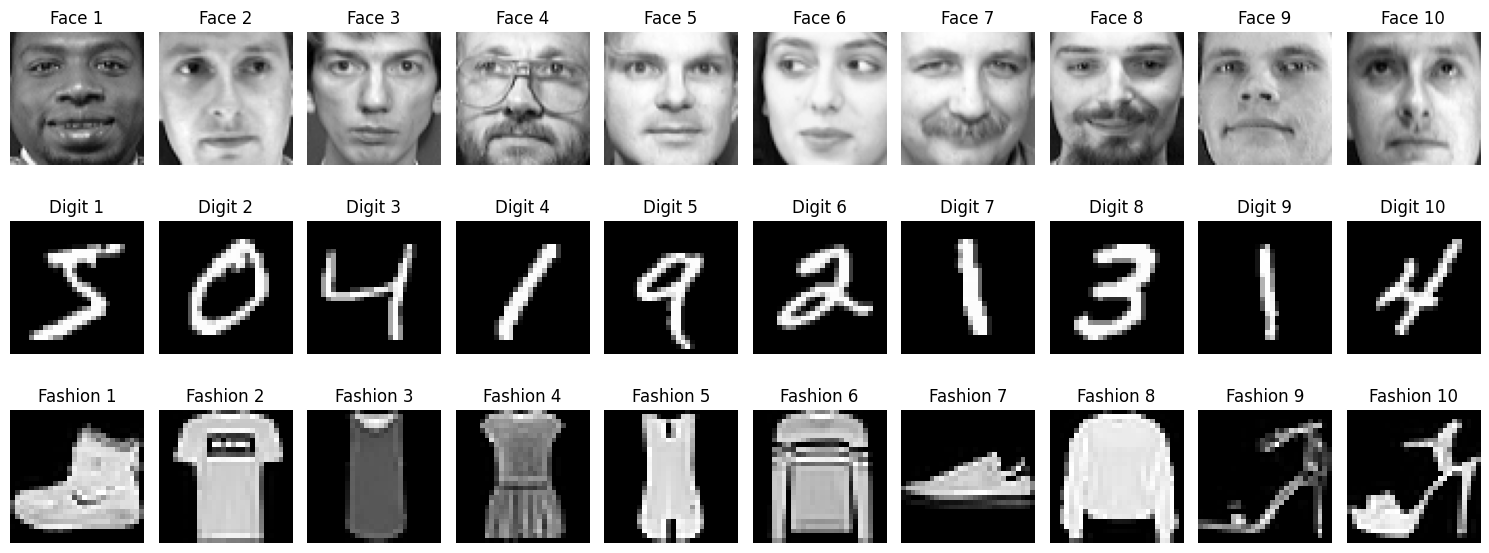

In [3]:
# Visualize datasets
def plot_dataset_samples(datasets, n_samples=10):
    """Plot samples from each dataset"""
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 6))
    
    # Faces
    X_faces_train, _ = datasets['faces']
    for i in range(n_samples):
        face = X_faces_train[i].reshape(64, 64)
        axes[0, i].imshow(face, cmap='gray')
        axes[0, i].set_title(f'Face {i+1}')
        axes[0, i].axis('off')
    
    # MNIST
    (X_mnist_train, _), _ = datasets['mnist']
    for i in range(n_samples):
        digit = X_mnist_train[i]
        axes[1, i].imshow(digit, cmap='gray')
        axes[1, i].set_title(f'Digit {i+1}')
        axes[1, i].axis('off')
    
    # Fashion-MNIST
    (X_fashion_train, _), _ = datasets['fashion']
    for i in range(n_samples):
        fashion = X_fashion_train[i]
        axes[2, i].imshow(fashion, cmap='gray')
        axes[2, i].set_title(f'Fashion {i+1}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot samples
plot_dataset_samples(datasets)

# Part I: Autoencoders

## 1. Pengantar Autoencoders

**Autoencoder** adalah neural network yang dilatih untuk mereproduksi inputnya. Struktur autoencoder terdiri dari:

1. **Encoder**: Menekan input ke representasi yang lebih kompak (latent/code)
2. **Decoder**: Merekonstruksi output dari representasi tersebut

### Kegunaan Autoencoders:
- **Dimensionality Reduction**: Alternatif untuk PCA
- **Feature Learning**: Belajar representasi yang berguna
- **Denoising**: Menghilangkan noise dari data
- **Anomaly Detection**: Mendeteksi data yang tidak normal
- **Data Generation**: Menghasilkan data baru (dengan variational autoencoders)

### Jenis-jenis Autoencoders:
1. **Undercomplete Autoencoders**: Dimensi latent < dimensi input
2. **Overcomplete Autoencoders**: Dimensi latent > dimensi input (butuh regularization)
3. **Sparse Autoencoders**: Menggunakan sparsity constraint
4. **Denoising Autoencoders**: Dilatih dengan noisy input
5. **Variational Autoencoders**: Probabilistic approach untuk generation

## 2. Undercomplete Autoencoders

Undercomplete autoencoder memiliki dimensi latent yang lebih kecil dari input, memaksa network untuk belajar representasi yang kompak. Mari kita implementasikan dan bandingkan dengan PCA.

In [ ]:
# Undercomplete Autoencoder untuk Faces Dataset
def create_undercomplete_autoencoder(input_dim, encoding_dim):
    """Create simple undercomplete autoencoder"""
    
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', name='encoder')(input_layer)
    
    # Decoder  
    decoded = layers.Dense(input_dim, activation='sigmoid', name='decoder')(encoded)
    
    # Autoencoder model
    autoencoder = Model(input_layer, decoded, name='autoencoder')
    
    # Encoder model (untuk extract representations)
    encoder = Model(input_layer, encoded, name='encoder_model')
    
    return autoencoder, encoder

# Prepare faces data
X_faces_train, X_faces_test = datasets['faces']
input_dim = X_faces_train.shape[1]  # 4096 (64x64)
encoding_dim = 32  # Compress to 32 dimensions

print(f"Input dimension: {input_dim}")
print(f"Encoding dimension: {encoding_dim}")
print(f"Compression ratio: {input_dim/encoding_dim:.1f}:1")

# Create and compile autoencoder
autoencoder, encoder = create_undercomplete_autoencoder(input_dim, encoding_dim)

autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
autoencoder.summary()

In [ ]:
# Train autoencoder
print("Training autoencoder...")
history = autoencoder.fit(
    X_faces_train, X_faces_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_faces_test, X_faces_test),
    verbose=1
)

# Train PCA for comparison
print("\nTraining PCA...")
scaler = StandardScaler()
X_faces_train_scaled = scaler.fit_transform(X_faces_train)
X_faces_test_scaled = scaler.transform(X_faces_test)

pca = PCA(n_components=encoding_dim)
pca.fit(X_faces_train_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")

# Get reconstructions
print("Getting reconstructions...")
# Autoencoder reconstructions
ae_reconstructions = autoencoder.predict(X_faces_test)

# PCA reconstructions
pca_encoded = pca.transform(X_faces_test_scaled)
pca_decoded_scaled = pca.inverse_transform(pca_encoded)
pca_reconstructions = scaler.inverse_transform(pca_decoded_scaled)

# Clip PCA reconstructions to [0, 1]
pca_reconstructions = np.clip(pca_reconstructions, 0, 1)

In [ ]:
# Visualize comparison
def compare_reconstructions(original, ae_recon, pca_recon, n_samples=5):
    """Compare original vs autoencoder vs PCA reconstructions"""
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 8))
    
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(original[i].reshape(64, 64), cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # Autoencoder
        axes[1, i].imshow(ae_recon[i].reshape(64, 64), cmap='gray')
        axes[1, i].set_title(f'Autoencoder {i+1}')
        axes[1, i].axis('off')
        
        # PCA
        axes[2, i].imshow(pca_recon[i].reshape(64, 64), cmap='gray')
        axes[2, i].set_title(f'PCA {i+1}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Autoencoder Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Compare reconstructions
compare_reconstructions(X_faces_test, ae_reconstructions, pca_reconstructions)

# Calculate reconstruction errors
ae_mse = np.mean((X_faces_test - ae_reconstructions) ** 2)
pca_mse = np.mean((X_faces_test - pca_reconstructions) ** 2)

print(f"Autoencoder MSE: {ae_mse:.6f}")
print(f"PCA MSE: {pca_mse:.6f}")
print(f"Autoencoder is {pca_mse/ae_mse:.2f}x better than PCA")

## 3. Stacked Autoencoders

Stacked autoencoders menggunakan multiple hidden layers untuk belajar representasi yang lebih kompleks. Mereka dapat menangkap non-linear relationships dalam data.

In [ ]:
# Stacked Autoencoder untuk MNIST
def create_stacked_autoencoder(input_shape, encoding_dims=[128, 64, 32]):
    """Create stacked autoencoder with multiple layers"""
    
    input_layer = Input(shape=input_shape)
    x = layers.Flatten()(input_layer)
    
    # Encoder
    encoded = x
    for i, dim in enumerate(encoding_dims):
        encoded = layers.Dense(dim, activation='relu', name=f'encoder_layer_{i+1}')(encoded)
    
    # Decoder (reverse order)
    decoded = encoded
    for i, dim in enumerate(reversed(encoding_dims[:-1])):
        decoded = layers.Dense(dim, activation='relu', name=f'decoder_layer_{i+1}')(decoded)
    
    # Output layer
    decoded = layers.Dense(np.prod(input_shape), activation='sigmoid')(decoded)
    decoded = layers.Reshape(input_shape)(decoded)
    
    # Models
    autoencoder = Model(input_layer, decoded, name='stacked_autoencoder')
    
    # Encoder model
    encoder_input = Input(shape=input_shape)
    x = layers.Flatten()(encoder_input)
    for i, dim in enumerate(encoding_dims):
        x = layers.Dense(dim, activation='relu', name=f'enc_layer_{i+1}')(x)
    encoder = Model(encoder_input, x, name='stacked_encoder')
    
    return autoencoder, encoder

# Prepare MNIST data
(X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test) = datasets['mnist']

# Create stacked autoencoder
input_shape = (28, 28)
encoding_dims = [512, 256, 128, 64]

stacked_autoencoder, stacked_encoder = create_stacked_autoencoder(input_shape, encoding_dims)

stacked_autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
stacked_autoencoder.summary()

In [ ]:
# Train stacked autoencoder
print("Training stacked autoencoder...")
stacked_history = stacked_autoencoder.fit(
    X_mnist_train, X_mnist_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_mnist_test, X_mnist_test),
    verbose=1
)

# Get reconstructions
stacked_reconstructions = stacked_autoencoder.predict(X_mnist_test[:100])

# Visualize results
def plot_mnist_reconstructions(original, reconstructed, n_samples=10):
    """Plot MNIST original vs reconstructed"""
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 4))
    
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(original[i], cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # Reconstructed
        axes[1, i].imshow(reconstructed[i], cmap='gray')
        axes[1, i].set_title(f'Reconstructed {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(stacked_history.history['loss'], label='Training Loss')
plt.plot(stacked_history.history['val_loss'], label='Validation Loss')
plt.title('Stacked Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(stacked_history.history['mse'], label='Training MSE')
plt.plot(stacked_history.history['val_mse'], label='Validation MSE')
plt.title('Stacked Autoencoder MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Show reconstructions
plot_mnist_reconstructions(X_mnist_test, stacked_reconstructions)

# Calculate reconstruction quality
stacked_mse = np.mean((X_mnist_test[:100] - stacked_reconstructions) ** 2)
print(f"Stacked Autoencoder MSE: {stacked_mse:.6f}")

## 4. Convolutional Autoencoders

Convolutional autoencoders sangat efektif untuk data gambar karena mereka mempertahankan spatial structure. Mereka menggunakan convolution layers di encoder dan deconvolution (transpose convolution) di decoder.

In [ ]:
# Convolutional Autoencoder untuk Fashion-MNIST
def create_conv_autoencoder(input_shape):
    """Create convolutional autoencoder"""
    
    input_layer = Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same', name='encoded')(x)
    
    # Get encoded shape for decoder
    encoded_shape = encoded.shape[1:]
    print(f"Encoded shape: {encoded_shape}")
    
    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # Output layer
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Models
    autoencoder = Model(input_layer, decoded, name='conv_autoencoder')
    
    # Encoder model
    encoder = Model(input_layer, encoded, name='conv_encoder')
    
    return autoencoder, encoder

# Prepare Fashion-MNIST data
(X_fashion_train, y_fashion_train), (X_fashion_test, y_fashion_test) = datasets['fashion']

# Reshape for CNN (add channel dimension)
X_fashion_train = X_fashion_train.reshape(-1, 28, 28, 1)
X_fashion_test = X_fashion_test.reshape(-1, 28, 28, 1)

print(f"Fashion-MNIST train shape: {X_fashion_train.shape}")
print(f"Fashion-MNIST test shape: {X_fashion_test.shape}")

# Create convolutional autoencoder
input_shape = (28, 28, 1)
conv_autoencoder, conv_encoder = create_conv_autoencoder(input_shape)

conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
conv_autoencoder.summary()

In [ ]:
# Train convolutional autoencoder
print("Training convolutional autoencoder...")
conv_history = conv_autoencoder.fit(
    X_fashion_train, X_fashion_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_fashion_test, X_fashion_test),
    verbose=1
)

# Get reconstructions and encoded representations
conv_reconstructions = conv_autoencoder.predict(X_fashion_test[:100])
conv_encoded = conv_encoder.predict(X_fashion_test[:100])

print(f"Original shape: {X_fashion_test[:100].shape}")
print(f"Encoded shape: {conv_encoded.shape}")
print(f"Reconstructed shape: {conv_reconstructions.shape}")

# Fashion-MNIST class names
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualize results
def plot_fashion_reconstructions(original, reconstructed, labels, n_samples=10):
    """Plot Fashion-MNIST original vs reconstructed with labels"""
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 4))
    
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(original[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'{fashion_class_names[labels[i]]}')
        axes[0, i].axis('off')
        
        # Reconstructed
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(conv_history.history['loss'], label='Training Loss')
plt.plot(conv_history.history['val_loss'], label='Validation Loss')
plt.title('Conv Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(conv_history.history['mse'], label='Training MSE')
plt.plot(conv_history.history['val_mse'], label='Validation MSE')
plt.title('Conv Autoencoder MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Show reconstructions
plot_fashion_reconstructions(X_fashion_test, conv_reconstructions, y_fashion_test)

# Calculate reconstruction quality
conv_mse = np.mean((X_fashion_test[:100] - conv_reconstructions) ** 2)
print(f"Convolutional Autoencoder MSE: {conv_mse:.6f}")

## 5. Denoising Autoencoders

Denoising autoencoders dilatih untuk merekonstruksi data asli dari input yang sudah diberi noise. Ini membantu model belajar representasi yang lebih robust dan dapat digunakan untuk menghilangkan noise dari data.

In [ ]:
# Denoising Autoencoder
def add_noise(data, noise_factor=0.3):
    """Add Gaussian noise to data"""
    noise = np.random.normal(0, 1, data.shape)
    noisy_data = data + noise_factor * noise
    return np.clip(noisy_data, 0, 1)

def create_denoising_autoencoder(input_shape):
    """Create denoising convolutional autoencoder"""
    
    input_layer = Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # Output layer
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_layer, decoded, name='denoising_autoencoder')
    
    return autoencoder

# Create noisy data
noise_factor = 0.3
X_mnist_train_noisy = add_noise(X_mnist_train.reshape(-1, 28, 28, 1), noise_factor)
X_mnist_test_noisy = add_noise(X_mnist_test.reshape(-1, 28, 28, 1), noise_factor)

print(f"Original MNIST range: [{X_mnist_train.min():.2f}, {X_mnist_train.max():.2f}]")
print(f"Noisy MNIST range: [{X_mnist_train_noisy.min():.2f}, {X_mnist_train_noisy.max():.2f}]")

# Create denoising autoencoder
denoising_autoencoder = create_denoising_autoencoder((28, 28, 1))
denoising_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
denoising_autoencoder.summary()

In [ ]:
# Train denoising autoencoder
print("Training denoising autoencoder...")
# Train on noisy input, target clean output
denoising_history = denoising_autoencoder.fit(
    X_mnist_train_noisy, X_mnist_train.reshape(-1, 28, 28, 1),
    epochs=15,
    batch_size=128,
    validation_data=(X_mnist_test_noisy, X_mnist_test.reshape(-1, 28, 28, 1)),
    verbose=1
)

# Get denoised reconstructions
denoised_images = denoising_autoencoder.predict(X_mnist_test_noisy[:100])

# Visualize denoising results
def plot_denoising_results(original, noisy, denoised, n_samples=10):
    """Plot original vs noisy vs denoised images"""
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 6))
    
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(original[i], cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # Noisy
        axes[1, i].imshow(noisy[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Noisy {i+1}')
        axes[1, i].axis('off')
        
        # Denoised
        axes[2, i].imshow(denoised[i].squeeze(), cmap='gray')
        axes[2, i].set_title(f'Denoised {i+1}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(denoising_history.history['loss'], label='Training Loss')
plt.plot(denoising_history.history['val_loss'], label='Validation Loss')
plt.title('Denoising Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(denoising_history.history['mae'], label='Training MAE')
plt.plot(denoising_history.history['val_mae'], label='Validation MAE')
plt.title('Denoising Autoencoder MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Show denoising results
plot_denoising_results(X_mnist_test, X_mnist_test_noisy, denoised_images)

# Calculate denoising performance
original_clean = X_mnist_test[:100].reshape(-1, 28, 28, 1)
mse_noisy = np.mean((original_clean - X_mnist_test_noisy[:100]) ** 2)
mse_denoised = np.mean((original_clean - denoised_images) ** 2)

print(f"MSE (Original vs Noisy): {mse_noisy:.6f}")
print(f"MSE (Original vs Denoised): {mse_denoised:.6f}")
print(f"Noise reduction: {((mse_noisy - mse_denoised) / mse_noisy * 100):.1f}%")

## 6. Sparse Autoencoders

Sparse autoencoders menggunakan regularization untuk memaksa sebagian besar neuron di hidden layer menjadi tidak aktif (sparse). Ada dua metode utama:
1. **L1 Regularization**: Menambahkan penalty berdasarkan L1 norm dari aktivasi
2. **KL Divergence**: Menambahkan penalty berdasarkan target sparsity level

In [ ]:
# Sparse Autoencoder dengan L1 Regularization
def create_sparse_autoencoder_l1(input_dim, encoding_dim, l1_reg=1e-5):
    """Create sparse autoencoder with L1 regularization"""
    
    input_layer = Input(shape=(input_dim,))
    
    # Encoder dengan L1 regularization
    encoded = layers.Dense(
        encoding_dim, 
        activation='relu',
        activity_regularizer=keras.regularizers.l1(l1_reg),
        name='sparse_encoder'
    )(input_layer)
    
    # Decoder
    decoded = layers.Dense(input_dim, activation='sigmoid', name='decoder')(encoded)
    
    autoencoder = Model(input_layer, decoded, name='sparse_autoencoder_l1')
    encoder = Model(input_layer, encoded, name='sparse_encoder_l1')
    
    return autoencoder, encoder

# KL Divergence Sparse Autoencoder
class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    """Custom KL divergence regularizer for sparsity"""
    
    def __init__(self, rho=0.05, beta=3):
        self.rho = rho  # Target sparsity
        self.beta = beta  # Regularization strength
    
    def __call__(self, x):
        # Calculate average activation across batch
        rho_hat = tf.reduce_mean(x, axis=0)
        
        # KL divergence
        kl_div = self.rho * tf.math.log(self.rho / (rho_hat + 1e-8)) + \
                (1 - self.rho) * tf.math.log((1 - self.rho) / (1 - rho_hat + 1e-8))
        
        return self.beta * tf.reduce_sum(kl_div)

def create_sparse_autoencoder_kl(input_dim, encoding_dim, rho=0.05, beta=3):
    """Create sparse autoencoder with KL divergence regularization"""
    
    input_layer = Input(shape=(input_dim,))
    
    # Encoder dengan KL regularization
    encoded = layers.Dense(
        encoding_dim,
        activation='sigmoid',  # Sigmoid for KL divergence
        activity_regularizer=KLDivergenceRegularizer(rho, beta),
        name='kl_sparse_encoder'
    )(input_layer)
    
    # Decoder
    decoded = layers.Dense(input_dim, activation='sigmoid', name='kl_decoder')(encoded)
    
    autoencoder = Model(input_layer, decoded, name='sparse_autoencoder_kl')
    encoder = Model(input_layer, encoded, name='sparse_encoder_kl')
    
    return autoencoder, encoder

# Use faces dataset for sparse autoencoders
X_faces_train, X_faces_test = datasets['faces']

# Create L1 sparse autoencoder
l1_autoencoder, l1_encoder = create_sparse_autoencoder_l1(
    input_dim=4096, 
    encoding_dim=128,
    l1_reg=1e-4
)

# Create KL sparse autoencoder
kl_autoencoder, kl_encoder = create_sparse_autoencoder_kl(
    input_dim=4096,
    encoding_dim=128,
    rho=0.05,
    beta=3
)

# Compile models
l1_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
kl_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("L1 Sparse Autoencoder:")
l1_autoencoder.summary()
print("\nKL Sparse Autoencoder:")
kl_autoencoder.summary()

In [ ]:
# Train sparse autoencoders
print("Training L1 sparse autoencoder...")
l1_history = l1_autoencoder.fit(
    X_faces_train, X_faces_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_faces_test, X_faces_test),
    verbose=1
)

print("\nTraining KL sparse autoencoder...")
kl_history = kl_autoencoder.fit(
    X_faces_train, X_faces_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_faces_test, X_faces_test),
    verbose=1
)

# Get encoded representations
l1_encoded = l1_encoder.predict(X_faces_test)
kl_encoded = kl_encoder.predict(X_faces_test)

# Calculate sparsity levels
def calculate_sparsity(encoded_data, threshold=0.1):
    """Calculate percentage of activations below threshold"""
    return np.mean(encoded_data < threshold) * 100

l1_sparsity = calculate_sparsity(l1_encoded)
kl_sparsity = calculate_sparsity(kl_encoded)

print(f"L1 Autoencoder sparsity: {l1_sparsity:.1f}%")
print(f"KL Autoencoder sparsity: {kl_sparsity:.1f}%")

# Get reconstructions
l1_reconstructions = l1_autoencoder.predict(X_faces_test[:20])
kl_reconstructions = kl_autoencoder.predict(X_faces_test[:20])

# Visualize sparsity
def plot_sparsity_analysis(l1_encoded, kl_encoded):
    """Plot activation distributions"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # L1 activations histogram
    axes[0, 0].hist(l1_encoded.flatten(), bins=50, alpha=0.7, color='blue')
    axes[0, 0].set_title('L1 Sparse Autoencoder Activations')
    axes[0, 0].set_xlabel('Activation Value')
    axes[0, 0].set_ylabel('Frequency')
    
    # KL activations histogram
    axes[0, 1].hist(kl_encoded.flatten(), bins=50, alpha=0.7, color='red')
    axes[0, 1].set_title('KL Sparse Autoencoder Activations')
    axes[0, 1].set_xlabel('Activation Value')
    axes[0, 1].set_ylabel('Frequency')
    
    # Average activations per neuron
    l1_avg = np.mean(l1_encoded, axis=0)
    kl_avg = np.mean(kl_encoded, axis=0)
    
    axes[1, 0].bar(range(len(l1_avg)), l1_avg, alpha=0.7, color='blue')
    axes[1, 0].set_title('L1 Average Activation per Neuron')
    axes[1, 0].set_xlabel('Neuron Index')
    axes[1, 0].set_ylabel('Average Activation')
    
    axes[1, 1].bar(range(len(kl_avg)), kl_avg, alpha=0.7, color='red')
    axes[1, 1].set_title('KL Average Activation per Neuron')
    axes[1, 1].set_xlabel('Neuron Index')
    axes[1, 1].set_ylabel('Average Activation')
    
    plt.tight_layout()
    plt.show()

# Visualize sparse reconstructions
def compare_sparse_reconstructions(original, l1_recon, kl_recon, n_samples=5):
    """Compare original vs L1 vs KL reconstructions"""
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 8))
    
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(original[i].reshape(64, 64), cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # L1 Sparse
        axes[1, i].imshow(l1_recon[i].reshape(64, 64), cmap='gray')
        axes[1, i].set_title(f'L1 Sparse {i+1}')
        axes[1, i].axis('off')
        
        # KL Sparse
        axes[2, i].imshow(kl_recon[i].reshape(64, 64), cmap='gray')
        axes[2, i].set_title(f'KL Sparse {i+1}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot analyses
plot_sparsity_analysis(l1_encoded, kl_encoded)
compare_sparse_reconstructions(X_faces_test, l1_reconstructions, kl_reconstructions)

# Calculate reconstruction errors
l1_mse = np.mean((X_faces_test[:20] - l1_reconstructions) ** 2)
kl_mse = np.mean((X_faces_test[:20] - kl_reconstructions) ** 2)

print(f"L1 Sparse Autoencoder MSE: {l1_mse:.6f}")
print(f"KL Sparse Autoencoder MSE: {kl_mse:.6f}")

## 7. Variational Autoencoders (VAE)

Variational Autoencoders adalah generative model yang dapat menghasilkan data baru. VAE berbeda dari autoencoder biasa karena:

1. **Probabilistic Encoding**: Encoder menghasilkan distribution (mean dan variance) bukan point estimate
2. **Reparameterization Trick**: Sampling dari distribution dilakukan dengan cara yang differentiable
3. **KL Divergence Loss**: Regularization agar latent space mendekati prior distribution (biasanya standard normal)

**Loss Function**: Reconstruction Loss + KL Divergence Loss

In [ ]:
# Variational Autoencoder Implementation
class VAE(Model):
    """Variational Autoencoder"""
    
    def __init__(self, input_dim, latent_dim=20, intermediate_dim=512):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        
        # Encoder
        self.encoder_input = layers.Dense(intermediate_dim, activation='relu')
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)
        
        # Decoder
        self.decoder_input = layers.Dense(intermediate_dim, activation='relu')
        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')
        
    def encode(self, x):
        """Encode input to latent distribution parameters"""
        h = self.encoder_input(x)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        return z_mean, z_log_var
    
    def reparameterize(self, z_mean, z_log_var):
        """Reparameterization trick"""
        batch_size = tf.shape(z_mean)[0]
        epsilon = tf.random.normal(shape=(batch_size, self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def decode(self, z):
        """Decode latent variable to reconstruction"""
        h = self.decoder_input(z)
        return self.decoder_output(h)
    
    def call(self, x):
        """Forward pass"""
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        return self.decode(z), z_mean, z_log_var

# VAE Loss Function
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    """VAE loss = reconstruction loss + KL divergence loss"""
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(y_true, y_pred), axis=1
        )
    )
    
    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )
    )
    
    return reconstruction_loss + kl_loss

# Training step
@tf.function
def train_step(vae, x, optimizer):
    """Single training step for VAE"""
    with tf.GradientTape() as tape:
        reconstruction, z_mean, z_log_var = vae(x)
        loss = vae_loss(x, reconstruction, z_mean, z_log_var)
    
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    
    return loss

# Create VAE for MNIST
(X_mnist_train, _), (X_mnist_test, _) = datasets['mnist']
X_mnist_train_flat = X_mnist_train.reshape(-1, 784)
X_mnist_test_flat = X_mnist_test.reshape(-1, 784)

# Initialize VAE
vae = VAE(input_dim=784, latent_dim=20, intermediate_dim=512)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

print("VAE Architecture:")
print(f"Input dim: {784}")
print(f"Latent dim: {20}")
print(f"Intermediate dim: {512}")

In [ ]:
# Train VAE
def train_vae(vae, train_data, test_data, epochs=20, batch_size=128):
    """Train VAE"""
    train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices(test_data).batch(batch_size)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        epoch_train_loss = 0
        num_batches = 0
        for batch in train_dataset:
            loss = train_step(vae, batch, optimizer)
            epoch_train_loss += loss
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        
        # Testing
        epoch_test_loss = 0
        num_test_batches = 0
        for batch in test_dataset:
            reconstruction, z_mean, z_log_var = vae(batch)
            test_loss = vae_loss(batch, reconstruction, z_mean, z_log_var)
            epoch_test_loss += test_loss
            num_test_batches += 1
        
        avg_test_loss = epoch_test_loss / num_test_batches
        
        train_losses.append(avg_train_loss.numpy())
        test_losses.append(avg_test_loss.numpy())
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")
    
    return train_losses, test_losses

print("Training VAE...")
train_losses, test_losses = train_vae(vae, X_mnist_train_flat, X_mnist_test_flat, epochs=20)

# Plot training history
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Generate new samples
def generate_samples(vae, n_samples=25):
    """Generate new samples from VAE"""
    # Sample from standard normal distribution
    random_latent = tf.random.normal(shape=(n_samples, vae.latent_dim))
    generated = vae.decode(random_latent)
    return generated.numpy()

# Generate and visualize new digits
generated_digits = generate_samples(vae, 25)

plt.subplot(1, 2, 2)
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
for i in range(25):
    row, col = i // 5, i % 5
    axes[row, col].imshow(generated_digits[i].reshape(28, 28), cmap='gray')
    axes[row, col].axis('off')
plt.suptitle('Generated Digits from VAE')
plt.tight_layout()
plt.show()

# Reconstruct test images
test_sample = X_mnist_test_flat[:10]
reconstructions, z_means, z_log_vars = vae(test_sample)

# Plot reconstructions
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    # Original
    axes[0, i].imshow(test_sample[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # Reconstructed
    axes[1, i].imshow(reconstructions[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title(f'Reconstructed {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("VAE training completed!")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final test loss: {test_losses[-1]:.4f}")

# Part II: Generative Adversarial Networks (GANs)

## 8. Pengantar GANs

**Generative Adversarial Networks (GANs)** adalah framework yang terdiri dari dua neural networks yang bersaing:

1. **Generator (G)**: Membuat data palsu yang mirip data asli
2. **Discriminator (D)**: Membedakan antara data asli dan data palsu

### Konsep Adversarial Training:
- **Generator** mencoba membuat data palsu yang dapat menipu discriminator
- **Discriminator** mencoba membedakan data asli dari data palsu
- Keduanya dilatih secara bersamaan dalam "game" zero-sum

### Aplikasi GANs:
- Image generation dan editing
- Style transfer
- Data augmentation
- Super resolution
- Domain adaptation

### Tantangan GANs:
- **Mode collapse**: Generator hanya menghasilkan sampel yang terbatas
- **Training instability**: Sulit mencapai nash equilibrium
- **Vanishing gradients**: Generator tidak mendapat gradients yang berguna

In [ ]:
# Basic GAN Implementation
class GAN:
    """Basic Generative Adversarial Network"""
    
    def __init__(self, input_dim=784, noise_dim=100):
        self.input_dim = input_dim
        self.noise_dim = noise_dim
        
        # Build generator and discriminator
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
        # Compile discriminator
        self.discriminator.compile(
            optimizer=keras.optimizers.Adam(0.0002, 0.5),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # For training generator, discriminator should not be trainable
        self.discriminator.trainable = False
        
        # Build combined model (generator + discriminator)
        noise_input = Input(shape=(self.noise_dim,))
        generated_image = self.generator(noise_input)
        validity = self.discriminator(generated_image)
        
        self.combined = Model(noise_input, validity)
        self.combined.compile(
            optimizer=keras.optimizers.Adam(0.0002, 0.5),
            loss='binary_crossentropy'
        )
        
    def build_generator(self):
        """Build generator network"""
        model = keras.Sequential([
            layers.Dense(256, input_dim=self.noise_dim),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            
            layers.Dense(512),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            
            layers.Dense(1024),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            
            layers.Dense(self.input_dim, activation='tanh')
        ], name='generator')
        
        return model
    
    def build_discriminator(self):
        """Build discriminator network"""
        model = keras.Sequential([
            layers.Dense(1024, input_dim=self.input_dim),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.3),
            
            layers.Dense(512),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.3),
            
            layers.Dense(256),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.3),
            
            layers.Dense(1, activation='sigmoid')
        ], name='discriminator')
        
        return model

# Initialize GAN
gan = GAN(input_dim=784, noise_dim=100)

print("Generator Architecture:")
gan.generator.summary()
print("\nDiscriminator Architecture:")
gan.discriminator.summary()

In [ ]:
# GAN Training
def train_gan(gan, X_train, epochs=10000, batch_size=128, sample_interval=1000):
    """Train GAN"""
    
    # Rescale training data to [-1, 1] (for tanh activation in generator)
    X_train = (X_train - 0.5) * 2
    
    # Ground truth labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        # Select random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        
        # Generate noise and fake images
        noise = np.random.normal(0, 1, (batch_size, gan.noise_dim))
        fake_images = gan.generator.predict(noise, verbose=0)
        
        # Train discriminator
        d_loss_real = gan.discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = gan.discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # -----------------
        #  Train Generator
        # -----------------
        
        # Generate noise
        noise = np.random.normal(0, 1, (batch_size, gan.noise_dim))
        
        # Train generator (wants discriminator to mistake fake as real)
        g_loss = gan.combined.train_on_batch(noise, real_labels)
        
        # Store losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        
        # Print progress and save samples
        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]:.4f}, D Acc: {100*d_loss[1]:.2f}%, G Loss: {g_loss:.4f}")
            
            # Save generated samples
            if epoch % (sample_interval * 2) == 0:
                sample_images(gan.generator, epoch)
    
    return d_losses, g_losses

def sample_images(generator, epoch, n_samples=25):
    """Generate and save sample images"""
    noise = np.random.normal(0, 1, (n_samples, 100))
    generated_images = generator.predict(noise, verbose=0)
    
    # Rescale to [0, 1]
    generated_images = (generated_images + 1) / 2
    
    fig, axes = plt.subplots(5, 5, figsize=(8, 8))
    for i in range(n_samples):
        row, col = i // 5, i % 5
        axes[row, col].imshow(generated_images[i].reshape(28, 28), cmap='gray')
        axes[row, col].axis('off')
    
    plt.suptitle(f'Generated Images - Epoch {epoch}')
    plt.tight_layout()
    plt.show()

# Prepare MNIST data for GAN training
X_mnist_train_flat = X_mnist_train.reshape(-1, 784).astype('float32')

print("Starting GAN training...")
print("Note: This will take some time. Reducing epochs for demo.")

# Train GAN (reduced epochs for demo)
d_losses, g_losses = train_gan(gan, X_mnist_train_flat, epochs=2000, sample_interval=500)

# Plot training losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
plt.plot(g_losses, label='Generator Loss', alpha=0.7)
plt.title('GAN Training Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Plot moving average for smoother visualization
window = 100
d_losses_smooth = np.convolve(d_losses, np.ones(window)/window, mode='valid')
g_losses_smooth = np.convolve(g_losses, np.ones(window)/window, mode='valid')
plt.plot(d_losses_smooth, label='D Loss (Smoothed)', alpha=0.7)
plt.plot(g_losses_smooth, label='G Loss (Smoothed)', alpha=0.7)
plt.title('GAN Training Losses (Smoothed)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("GAN training completed!")

## 9. Deep Convolutional GANs (DCGANs)

DCGAN adalah versi convolutional dari GAN yang lebih stabil dan menghasilkan gambar berkualitas lebih tinggi. DCGAN menggunakan:

1. **Convolution/Transpose Convolution** sebagai pengganti fully connected layers
2. **Batch Normalization** untuk stabilitas training
3. **LeakyReLU** di discriminator, **ReLU** di generator
4. **No max pooling** - menggunakan strided convolutions

In [ ]:
# DCGAN Implementation
class DCGAN:
    """Deep Convolutional GAN"""
    
    def __init__(self, img_shape=(28, 28, 1), noise_dim=100):
        self.img_shape = img_shape
        self.noise_dim = noise_dim
        
        # Build generator and discriminator
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
        # Compile discriminator
        self.discriminator.compile(
            optimizer=keras.optimizers.Adam(0.0002, 0.5),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Combined model for training generator
        self.discriminator.trainable = False
        noise_input = Input(shape=(self.noise_dim,))
        generated_image = self.generator(noise_input)
        validity = self.discriminator(generated_image)
        
        self.combined = Model(noise_input, validity)
        self.combined.compile(
            optimizer=keras.optimizers.Adam(0.0002, 0.5),
            loss='binary_crossentropy'
        )
    
    def build_generator(self):
        """Build DCGAN generator"""
        model = keras.Sequential([
            # Input layer
            layers.Dense(7 * 7 * 256, input_dim=self.noise_dim),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Reshape((7, 7, 256)),
            
            # Upsample to 14x14
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            
            # Upsample to 28x28
            layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            
            # Output layer
            layers.Conv2D(1, (3, 3), activation='tanh', padding='same')
        ], name='dcgan_generator')
        
        return model
    
    def build_discriminator(self):
        """Build DCGAN discriminator"""
        model = keras.Sequential([
            # Input layer
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', 
                         input_shape=self.img_shape),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.25),
            
            # Downsample
            layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.25),
            
            # Downsample
            layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.25),
            
            # Output
            layers.Flatten(),
            layers.Dense(1, activation='sigmoid')
        ], name='dcgan_discriminator')
        
        return model

# Initialize DCGAN
dcgan = DCGAN(img_shape=(28, 28, 1), noise_dim=100)

print("DCGAN Generator Architecture:")
dcgan.generator.summary()
print("\nDCGAN Discriminator Architecture:")
dcgan.discriminator.summary()

In [ ]:
# Train DCGAN
def train_dcgan(dcgan, X_train, epochs=5000, batch_size=128, sample_interval=1000):
    """Train DCGAN"""
    
    # Rescale training data to [-1, 1]
    X_train = (X_train - 0.5) * 2
    
    # Ground truth labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        # Select random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        
        # Generate noise and fake images
        noise = np.random.normal(0, 1, (batch_size, dcgan.noise_dim))
        fake_images = dcgan.generator.predict(noise, verbose=0)
        
        # Train discriminator
        d_loss_real = dcgan.discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = dcgan.discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # -----------------
        #  Train Generator
        # -----------------
        
        # Generate noise
        noise = np.random.normal(0, 1, (batch_size, dcgan.noise_dim))
        
        # Train generator
        g_loss = dcgan.combined.train_on_batch(noise, real_labels)
        
        # Store losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        
        # Print progress and save samples
        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]:.4f}, D Acc: {100*d_loss[1]:.2f}%, G Loss: {g_loss:.4f}")
            
            # Save generated samples
            if epoch % (sample_interval * 2) == 0:
                sample_dcgan_images(dcgan.generator, epoch)
    
    return d_losses, g_losses

def sample_dcgan_images(generator, epoch, n_samples=25):
    """Generate and save DCGAN sample images"""
    noise = np.random.normal(0, 1, (n_samples, 100))
    generated_images = generator.predict(noise, verbose=0)
    
    # Rescale to [0, 1]
    generated_images = (generated_images + 1) / 2
    
    fig, axes = plt.subplots(5, 5, figsize=(8, 8))
    for i in range(n_samples):
        row, col = i // 5, i % 5
        axes[row, col].imshow(generated_images[i, :, :, 0], cmap='gray')
        axes[row, col].axis('off')
    
    plt.suptitle(f'DCGAN Generated Images - Epoch {epoch}')
    plt.tight_layout()
    plt.show()

# Prepare data for DCGAN
X_mnist_train_dcgan = X_mnist_train.reshape(-1, 28, 28, 1).astype('float32')

print("Starting DCGAN training...")
print("Note: Using reduced epochs for demo.")

# Train DCGAN (reduced epochs for demo)
dcgan_d_losses, dcgan_g_losses = train_dcgan(dcgan, X_mnist_train_dcgan, epochs=1500, sample_interval=500)

# Plot DCGAN training losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(dcgan_d_losses, label='DCGAN Discriminator Loss', alpha=0.7)
plt.plot(dcgan_g_losses, label='DCGAN Generator Loss', alpha=0.7)
plt.title('DCGAN Training Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Compare with basic GAN losses (if available)
if 'd_losses' in locals():
    plt.plot(d_losses[:len(dcgan_d_losses)], label='Basic GAN D Loss', alpha=0.7)
    plt.plot(g_losses[:len(dcgan_g_losses)], label='Basic GAN G Loss', alpha=0.7)
plt.plot(dcgan_d_losses, label='DCGAN D Loss', alpha=0.7)
plt.plot(dcgan_g_losses, label='DCGAN G Loss', alpha=0.7)
plt.title('GAN vs DCGAN Comparison')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("DCGAN training completed!")

## 10. Evaluasi dan Best Practices

### Evaluasi Autoencoders:
1. **Reconstruction Error**: MSE, MAE antara input dan output
2. **Visualization**: Plot original vs reconstructed images
3. **Latent Space Analysis**: Visualisasi representasi dalam ruang dimensional rendah
4. **Downstream Task Performance**: Seberapa baik features untuk klasifikasi

### Evaluasi GANs:
1. **Visual Inspection**: Kualitas gambar yang dihasilkan
2. **Mode Collapse Detection**: Keragaman output
3. **Training Stability**: Konvergensi loss functions
4. **Quantitative Metrics**: FID (Fréchet Inception Distance), IS (Inception Score)

### Best Practices untuk Autoencoders:
- Gunakan appropriate activation functions (sigmoid untuk [0,1], tanh untuk [-1,1])
- Batch normalization untuk deep networks
- Dropout untuk regularization
- Learning rate scheduling
- Early stopping berdasarkan validation loss

### Best Practices untuk GANs:
- Balance generator dan discriminator training
- Use different learning rates (often slower for generator)
- Batch normalization (tapi tidak di output layers)
- Avoid mode collapse dengan techniques seperti mini-batch discrimination
- Monitor training carefully - GANs can be unstable

In [ ]:
# Model Evaluation dan Comparison
def evaluate_models():
    """Comprehensive evaluation of all models"""
    
    print("=== MODEL EVALUATION SUMMARY ===\n")
    
    # Autoencoder Comparison
    print("1. AUTOENCODER COMPARISON:")
    print("-" * 50)
    
    if 'autoencoder' in locals():
        ae_test_loss = autoencoder.evaluate(X_faces_test, X_faces_test, verbose=0)
        print(f"Undercomplete AE - Loss: {ae_test_loss[0]:.6f}, MAE: {ae_test_loss[1]:.6f}")
    
    if 'stacked_autoencoder' in locals():
        stacked_test_loss = stacked_autoencoder.evaluate(X_mnist_test, X_mnist_test, verbose=0)
        print(f"Stacked AE - Loss: {stacked_test_loss[0]:.6f}, MSE: {stacked_test_loss[1]:.6f}")
    
    if 'conv_autoencoder' in locals():
        conv_test_loss = conv_autoencoder.evaluate(X_fashion_test, X_fashion_test, verbose=0)
        print(f"Convolutional AE - Loss: {conv_test_loss[0]:.6f}, MSE: {conv_test_loss[1]:.6f}")
    
    if 'denoising_autoencoder' in locals():
        denoising_test_loss = denoising_autoencoder.evaluate(
            X_mnist_test_noisy[:1000], X_mnist_test[:1000].reshape(-1, 28, 28, 1), 
            verbose=0
        )
        print(f"Denoising AE - Loss: {denoising_test_loss[0]:.6f}, MAE: {denoising_test_loss[1]:.6f}")
    
    print(f"L1 Sparse AE - MSE: {l1_mse:.6f}, Sparsity: {l1_sparsity:.1f}%")
    print(f"KL Sparse AE - MSE: {kl_mse:.6f}, Sparsity: {kl_sparsity:.1f}%")
    
    print(f"\n2. GENERATIVE MODELS:")
    print("-" * 50)
    print(f"VAE - Final Loss: {train_losses[-1]:.4f}")
    print(f"Basic GAN - Final D Loss: {d_losses[-1]:.4f}, G Loss: {g_losses[-1]:.4f}")
    print(f"DCGAN - Final D Loss: {dcgan_d_losses[-1]:.4f}, G Loss: {dcgan_g_losses[-1]:.4f}")

# Latent Space Visualization
def visualize_latent_space():
    """Visualize latent representations"""
    
    print("\n3. LATENT SPACE ANALYSIS:")
    print("-" * 50)
    
    # VAE latent space visualization
    if 'vae' in locals():
        test_sample = X_mnist_test_flat[:1000]
        _, z_means, _ = vae(test_sample)
        
        # Use PCA to reduce to 2D for visualization
        from sklearn.decomposition import PCA
        pca_latent = PCA(n_components=2)
        z_2d = pca_latent.fit_transform(z_means.numpy())
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_mnist_test[:1000], cmap='tab10', alpha=0.7)
        plt.colorbar(scatter)
        plt.title('VAE Latent Space (2D PCA)')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        
        # Latent space interpolation
        plt.subplot(1, 2, 2)
        # Generate a grid in latent space
        n_grid = 15
        x_values = np.linspace(-3, 3, n_grid)
        y_values = np.linspace(-3, 3, n_grid)
        
        canvas = np.zeros((28 * n_grid, 28 * n_grid))
        for i, x in enumerate(x_values):
            for j, y in enumerate(y_values):
                # Sample point in 2D, pad with zeros for higher dimensions
                z_sample = np.zeros((1, vae.latent_dim))
                z_sample[0, 0] = x
                z_sample[0, 1] = y
                
                generated = vae.decode(z_sample).numpy()
                canvas[i*28:(i+1)*28, j*28:(j+1)*28] = generated[0].reshape(28, 28)
        
        plt.imshow(canvas, cmap='gray')
        plt.title('VAE Latent Space Interpolation')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Comparison of Generation Quality
def compare_generation_quality():
    """Compare generation quality across models"""
    
    print("\n4. GENERATION QUALITY COMPARISON:")
    print("-" * 50)
    
    fig, axes = plt.subplots(3, 10, figsize=(15, 6))
    
    # VAE generations
    if 'vae' in locals():
        vae_samples = generate_samples(vae, 10)
        for i in range(10):
            axes[0, i].imshow(vae_samples[i].reshape(28, 28), cmap='gray')
            axes[0, i].set_title(f'VAE {i+1}')
            axes[0, i].axis('off')
    
    # Basic GAN generations
    if 'gan' in locals():
        noise = np.random.normal(0, 1, (10, 100))
        gan_samples = gan.generator.predict(noise, verbose=0)
        gan_samples = (gan_samples + 1) / 2  # Rescale to [0, 1]
        
        for i in range(10):
            axes[1, i].imshow(gan_samples[i].reshape(28, 28), cmap='gray')
            axes[1, i].set_title(f'GAN {i+1}')
            axes[1, i].axis('off')
    
    # DCGAN generations
    if 'dcgan' in locals():
        noise = np.random.normal(0, 1, (10, 100))
        dcgan_samples = dcgan.generator.predict(noise, verbose=0)
        dcgan_samples = (dcgan_samples + 1) / 2  # Rescale to [0, 1]
        
        for i in range(10):
            axes[2, i].imshow(dcgan_samples[i, :, :, 0], cmap='gray')
            axes[2, i].set_title(f'DCGAN {i+1}')
            axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run comprehensive evaluation
evaluate_models()
visualize_latent_space()
compare_generation_quality()

## 11. Kesimpulan

### Rangkuman Chapter 17:

**Autoencoders:**
1. **Undercomplete**: Untuk dimensionality reduction dan feature learning
2. **Stacked**: Deep autoencoders untuk representasi kompleks
3. **Convolutional**: Ideal untuk data gambar dengan spatial structure
4. **Denoising**: Untuk noise reduction dan robust representations
5. **Sparse**: Menggunakan regularization untuk sparse representations
6. **Variational**: Probabilistic approach untuk generation

**GANs:**
1. **Basic GAN**: Foundation dengan adversarial training
2. **DCGAN**: Convolutional approach untuk better image generation

### Kapan Menggunakan Apa:

**Autoencoders:**
- **Dimensionality reduction**: Undercomplete/Sparse AE
- **Noise removal**: Denoising AE
- **Feature extraction**: Stacked/Convolutional AE
- **Data generation**: Variational AE

**GANs:**
- **High-quality image generation**: DCGAN
- **Data augmentation**: Basic GAN
- **Creative applications**: Advanced GAN variants

### Key Takeaways:

1. **Autoencoders** excel at learning efficient representations
2. **VAEs** provide principled approach to generation with continuous latent space
3. **GANs** can generate very realistic samples but are harder to train
4. **Training stability** is crucial - monitor losses and outputs carefully
5. **Architecture matters** - choose based on your data type and objectives

### Next Steps:
- Explore advanced GAN variants (StyleGAN, CycleGAN, etc.)
- Learn about Transformer-based generative models
- Study recent developments in diffusion models
- Apply these techniques to domain-specific problems